In [6]:
import numpy as np
import json, re, os, sys
import pandas as pd
import matplotlib.pyplot as plt
import time, random, openpyxl

In [7]:
decisions = ['OK', 'Revision required', 'Rejected']
scenarios = ['Fault Analysis & Diagnostics', 'Network Configuration', 'Software Deployment', 'Monitoring and Alerts', 'Performance Optimization', 'Automation Scripts', 'Others', 'General Knowledge']
abilities = ['Knowledge Recall', 'Reasoning', 'Operation']
scene_id_dt = {scene: [] for scene in scenarios}
ability_id_dt = {ability: [] for ability in abilities}

In [8]:
# 需要从15个batch中整合题目的内容
batch_dir = "/mnt/mfs/opsgpt/opencompass/experiments/result_analysis/label_batches"
for excel_file in os.listdir(batch_dir):
    filename = os.path.join(batch_dir, excel_file)
    excel = pd.ExcelFile(filename)
    df = pd.read_excel(filename, sheet_name='Sheet1')
    # print(df.columns) # Index(['topic', 'gpt_analysis', 'task', 'decision', 'scenario', 'ability', 'statement', 'answer', 'id', 'domain', 'note'], dtype='object')
    for ridx, row in df.iterrows():
        scene_id_dt[row['scenario']].append(row['id'])
        ability_id_dt[row['ability']].append(row['id'])

id_scene_dt = {qid: scene for scene in scene_id_dt for qid in scene_id_dt[scene]}
id_ability_dt = {qid: ability for ability in ability_id_dt for qid in ability_id_dt[ability]}

/opt/conda/envs/opencompass/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/opt/conda/envs/opencompass/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/opt/conda/envs/opencompass/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/opt/conda/envs/opencompass/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [14]:
# 现在该统计每个模型在各类上的表现了！不如直接加起来！然后取平均值！

models = [
    "baichuan-13b-chat",
    "chinese-alpaca-2-13b",
    "GPT-3.5-turbo",     
    "llama-2-13b-chat",  
    "qwen_chat_7b",
    "chatglm2-6b",        
    "chinese-llama-2-13b",   
    "internlm_chat_7b",  
    "llama-2-70b-int4",
    "llama-2-7b-chat"
]

with open("/mnt/mfs/opsgpt/opencompass/experiments/result_analysis/results.json", 'r') as f:
    data = json.load(f)

scene_model_dt = dict()
ability_model_dt = dict()

for model in models:
    """统计每个模型的两个维度的准确率
    """
    scene_result = {scene:[] for scene in scenarios}
    ability_result = {ability:[] for ability in abilities}
    
    for result in data:
        if result['model'] == model:
            for qid, value in result['result'].items():
                if qid not in id_scene_dt:
                    continue
                scene = id_scene_dt[qid]
                ability = id_ability_dt[qid]
                scene_result[scene].append(value)
                ability_result[ability].append(value)
    
    try:
        scene_score = {scene: sum(result)/len(result) for scene, result in scene_result.items()}
        ability_score = {ability: sum(result)/len(result) for ability, result in ability_result.items()}
        # print(scene_score)
        # print(ability_score)
        model_scene_list = [scene_score[scene] for scene in scenarios]
        model_ability_list = [ability_score[ability] for ability in abilities]
        scene_model_dt[model] = model_scene_list
        ability_model_dt[model] = model_ability_list
    except:
        continue

print(scene_model_dt)
print(ability_model_dt)



{'Fault Analysis & Diagnostics': 0.28771551724137934, 'Network Configuration': 0.29191616766467066, 'Software Deployment': 0.3482142857142857, 'Monitoring and Alerts': 0.3576388888888889, 'Performance Optimization': 0.3263888888888889, 'Automation Scripts': 0.3472222222222222, 'Others': 0.28618421052631576, 'General Knowledge': 0.3236363636363636}
{'Knowledge Recall': 0.32894736842105265, 'Reasoning': 0.28678929765886285, 'Operation': 0.325}
{'Fault Analysis & Diagnostics': 0.4331896551724138, 'Network Configuration': 0.42664670658682635, 'Software Deployment': 0.5089285714285714, 'Monitoring and Alerts': 0.5694444444444444, 'Performance Optimization': 0.4791666666666667, 'Automation Scripts': 0.5416666666666666, 'Others': 0.40460526315789475, 'General Knowledge': 0.45636363636363636}
{'Knowledge Recall': 0.4605263157894737, 'Reasoning': 0.4406354515050167, 'Operation': 0.48}
{'Fault Analysis & Diagnostics': 0.65625, 'Network Configuration': 0.6781437125748503, 'Software Deployment': 0

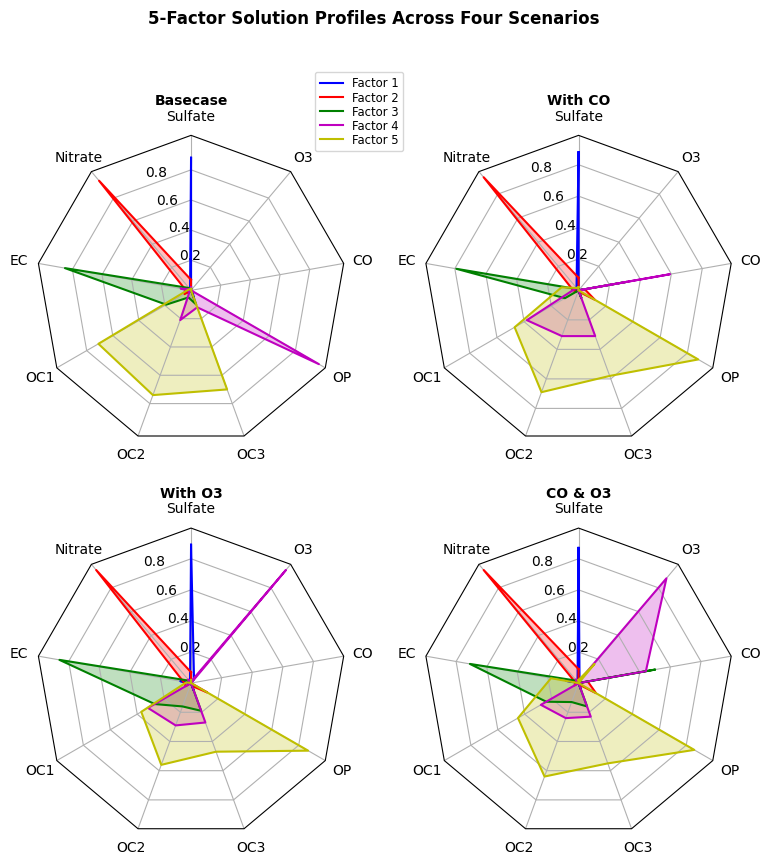

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

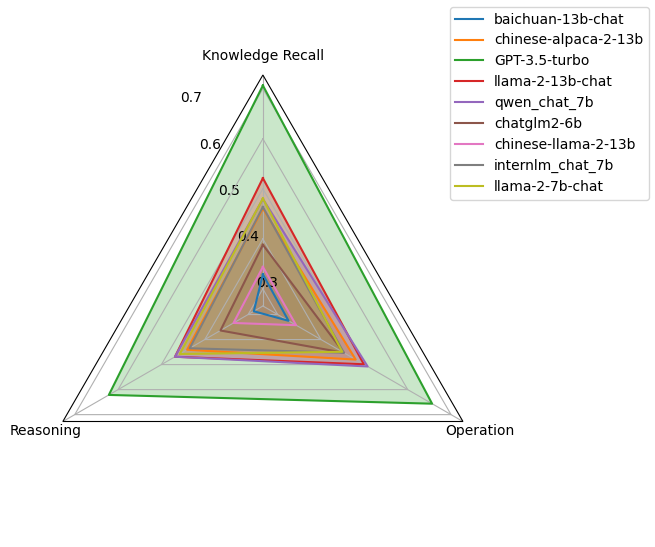

In [84]:
N = len(abilities)
theta = radar_factory(N, frame='polygon')

spoke_labels = abilities
title = "LLMs' Performance on Different Abilities"
case_data = [
    ability_model_dt[model] for model in models if model in ability_model_dt
]

fig, ax = plt.subplots(figsize=(8,6), subplot_kw=dict(projection='radar'))
# fig.tight_layout()
    
ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
# ax.set_title(title, ha='center')

for d in case_data:
    line = ax.plot(theta, d)
    ax.fill(theta, d,  alpha=0.25, label='_nolegend_')
ax.set_varlabels(spoke_labels)
fig.legend([model for model in models if model in ability_model_dt])

plt.savefig("ability.pdf", format="pdf")
plt.show()

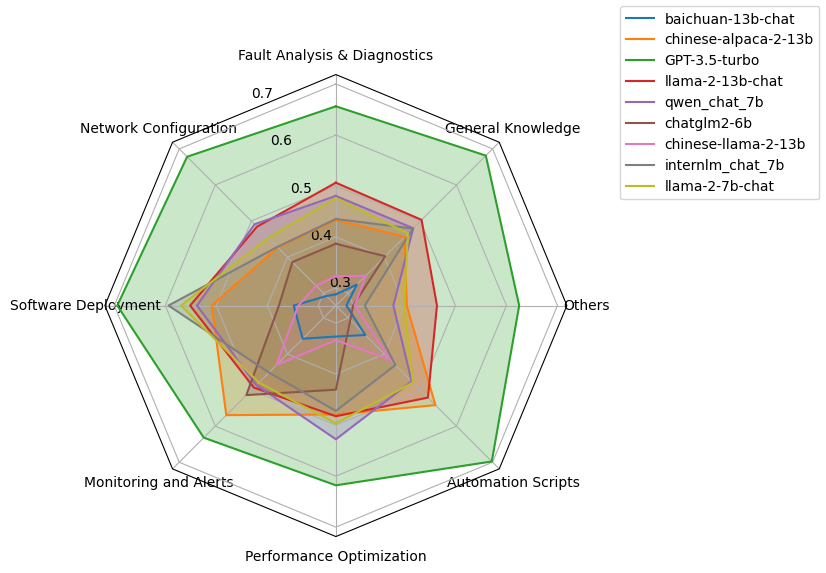

In [83]:
N = len(scenarios)
theta = radar_factory(N, frame='polygon')

spoke_labels = scenarios
title = "LLMs' Performance on Different Scenarios"
case_data = [
    scene_model_dt[model] for model in models if model in scene_model_dt
]

fig, ax = plt.subplots(figsize=(10,6), subplot_kw=dict(projection='radar'))
# fig.tight_layout()
    
ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
# ax.set_title(title, ha='center')

for d in case_data:
    line = ax.plot(theta, d)
    ax.fill(theta, d,  alpha=0.25, label='_nolegend_')
ax.set_varlabels(spoke_labels)
fig.legend([model for model in models if model in scene_model_dt])

plt.savefig("scene.pdf", format="pdf")
plt.show()

Monitoring and Alerts Operation
Others Operation


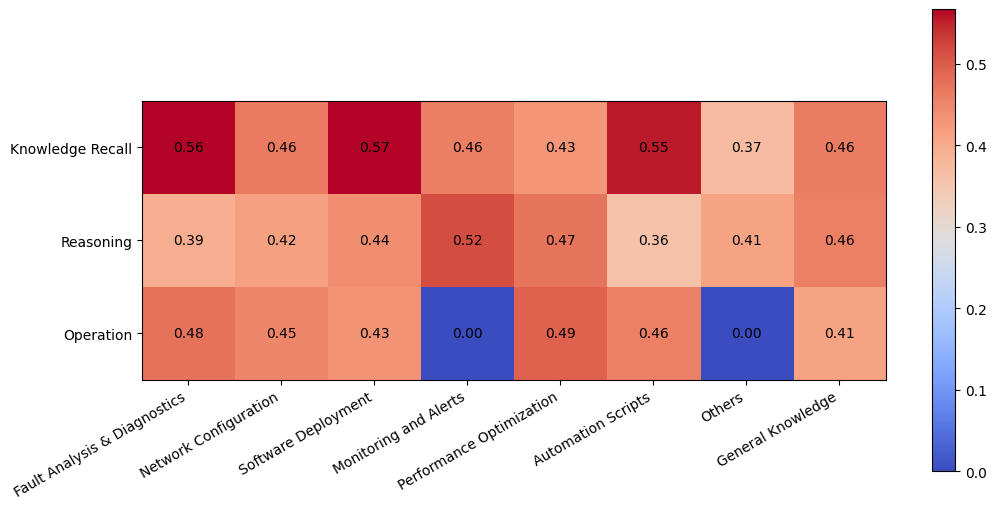

In [89]:

scene_ability_result = {scene: {ability: [] for ability in abilities} for scene in scenarios}
with open("/mnt/mfs/opsgpt/opencompass/experiments/result_analysis/results.json", 'r') as f:
    data = json.load(f)

for model in models:
    """统计每个模型的两个维度的准确率
    """
    
    for result in data:
        for qid, value in result['result'].items():
            if qid not in id_scene_dt:
                continue
            scene = id_scene_dt[qid]
            ability = id_ability_dt[qid]
            scene_ability_result[scene][ability].append(value)

data = []
for scene in scenarios:
    temp = []
    for ability in abilities:
        if len(scene_ability_result[scene][ability]) == 0:
            print(scene, ability)
            temp.append(0)
        else:
            temp.append(sum(scene_ability_result[scene][ability])/len(scene_ability_result[scene][ability]))
    data.append(temp)
data = np.array(data).transpose()

x_labels = scenarios
y_labels = abilities
# 创建一个图形对象
fig, ax = plt.subplots(figsize=(12,6))
# fig.tight_layout()

# 创建一个热力图
heatmap = ax.imshow(data, cmap='coolwarm', interpolation='nearest')

# 添加颜色条
cbar = plt.colorbar(heatmap)

# 设置坐标轴标签
ax.set_xticks(np.arange(len(x_labels)))
ax.set_yticks(np.arange(len(y_labels)))
ax.set_xticklabels(x_labels, rotation=30, ha='right')
ax.set_yticklabels(y_labels)

# 在每个方块中添加数值标签
for i in range(len(x_labels)):
    for j in range(len(y_labels)):
        text = ax.text(i, j, f'{data[j, i]:.2f}', ha='center', va='center', color='black')

# 添加标题
# plt.title("LLMs' Average Performance on Scenarios and Abilities")
plt.savefig("scene_ability.pdf", format='pdf')
# 显示图形
plt.show()